In [1]:
# Imports
# 
# Note: these are all the imports you need for this assignment!
# Do not import any other functions / packages

# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# map
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# remove warnings
import warnings
warnings.filterwarnings('ignore')

## load data from global terrorism db

In [ ]:
df = pd.read_excel('globalterrorismdb_0919dist.xlsx') # (191464, 135)

### preprocess the data to select useful columns

In [4]:
df = df[['iyear','imonth','iday','country','country_txt','region','region_txt','provstate','city','latitude','longitude','success','attacktype1','attacktype1_txt','weaptype1','weaptype1_txt','weapsubtype1','weapsubtype1_txt','suicide','targtype1','targtype1_txt','targsubtype1','targsubtype1_txt','natlty1','natlty1_txt','gname','motive','nperps','nperpcap','claimed','nkill','nkillus','nkillter','nwound','nwoundus','property','propextent','propvalue','ishostkid','nhostkid','nhostkidus','ransom','ransomamt','hostkidoutcome']]

### plot terrorism incidents trends for overview

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f7c6d5eb8>]],
      dtype=object)

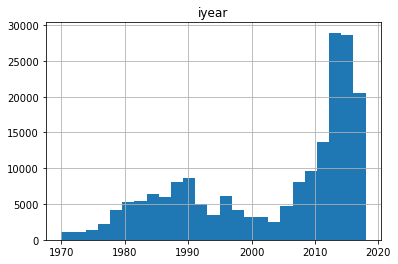

In [77]:
df[['iyear']].hist(bins=25)

#### process nationality/country to dictionary 

In [6]:
nationality_codes = []
nationality_txt = []

filepath = 'nationality_dict.txt'
f = open(filepath, "r", encoding='utf-8-sig')
for x in f:
    tmp_list = x.split('=')
    tmp_code = int(tmp_list[0].strip())
    tmp_txt = tmp_list[1].strip()
    nationality_codes.append(tmp_code)
    nationality_txt.append(tmp_txt)
f.close()

nationality_dict = dict(zip(nationality_codes, nationality_txt))
nationality_map_tmp = range(225)
nationality_idx_map_dict = dict(zip(nationality_map_tmp, nationality_codes)) 

In [7]:
import copy
country_dict = copy.deepcopy(nationality_dict)
country_code = copy.deepcopy(nationality_codes)

# delete only countries that only appear as target/victim descriptors in the GTD.
to_del_countries_key_list = [24, 79, 114, 125, 126, 134, 152, 163, 169, 192, 206, 212, 216, 225, 233, 238, 334, 351, 520, 999, ]
for i in to_del_countries_key_list: 
    del country_dict[i]
    country_code.remove(i)

## get country data from World Bank (GDP,Population,...) called country_data_df

In [109]:
country_data_df = pd.read_csv('country_data.csv')
country_data_df.shape

(9338, 53)

### data clean country_data_df

#### drop useless columns and rename columns 

In [112]:
country_data_df.drop(['Series Code','Country Code'], axis=1, inplace=True)

In [113]:
new_col_2 = list(range(1970, 2019))
for i in range(0, len(new_col_2)): 
    new_col_2[i] = str(new_col_2[i]) 
new_col_1 = ['type', 'country']
new_col = new_col_1 + new_col_2
country_data_df.columns = new_col

In [123]:
country_data_df = country_data_df[country_data_df['country'].notnull()]

#### rename some of the country names of country_data_df to be consistent with df

In [125]:
# replace left with right 
# Bahamas, The;Bahamas
# Bosnia and Herzegovina;Bosnia-Herzegovina
# Brunei Darussalam;Brunei
# Congo,Rep.;Republic of the Congo
# Egypt,Arab Rep.;Egypt
# Gambia,The;Gambia
# Hong Kong SAR,China;Hong Kong
# Iran, Islamic Rep.;Iran
# Côte d'Ivoire;Ivory Coast
# Kyrgyz Republic;Kyrgyzstan
# Lao PDR;Laos
# Macao SAR,China;Macau
# North Macedonia;Macedonia
# Korea, Dem. People’s Rep.;North Korea
# Russian Federation;Russia
# Korea, Rep.;south korea
# Eswatini;Swaziland
# Syrian Arab Republic;Syria
# Venezuela, RB;Venezuela
# Yemen,Rep.;Yemen
# Congo,Dem.Rep.;Democratic Republic of the Congo
# Timor-Leste;East Timor

country_data_df['country'].replace('Bosnia and Herzegovina','Bosnia-Herzegovina', inplace=True)
country_data_df['country'].replace('Brunei Darussalam','Brunei', inplace=True)
country_data_df['country'].replace('Bahamas, The','Bahamas', inplace=True)
country_data_df['country'].replace('Congo, Rep.','Republic of the Congo', inplace=True)
country_data_df['country'].replace('Egypt, Arab Rep.','Egypt', inplace=True)
country_data_df['country'].replace('Gambia, The','Gambia', inplace=True)
country_data_df['country'].replace('Hong Kong SAR, China','Hong Kong', inplace=True)
country_data_df['country'].replace('Iran, Islamic Rep.','Iran', inplace=True)
country_data_df['country'].replace("Cote d'Ivoire",'Ivory Coast', inplace=True)
country_data_df['country'].replace('Kyrgyz Republic','Kyrgyzstan', inplace=True)
country_data_df['country'].replace('Lao PDR','Laos', inplace=True)
country_data_df['country'].replace('Macao SAR, China','Macau', inplace=True)
country_data_df['country'].replace('North Macedonia','Macedonia', inplace=True)
country_data_df['country'].replace('Korea, Dem. People’s Rep.','North Korea', inplace=True)
country_data_df['country'].replace('Russian Federation','Russia', inplace=True)
country_data_df['country'].replace('Korea, Rep.','South Korea', inplace=True)
country_data_df['country'].replace('Eswatini','Swaziland', inplace=True)
country_data_df['country'].replace('Syrian Arab Republic','Syria', inplace=True)
country_data_df['country'].replace('Venezuela, RB','Venezuela', inplace=True)
country_data_df['country'].replace('Yemen, Rep.','Yemen', inplace=True)
country_data_df['country'].replace('Congo, Dem. Rep.','Democratic Republic of the Congo', inplace=True)
country_data_df['country'].replace('Timor-Leste','East Timor', inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


#### standardize some contry in df  (these countries change name)

In [126]:
# ;People's Republic of the Congo  --> same as 'Republic of the Congo'
# ;Zaire -->  same as 'Democratic Republic of the Congo'
# ;East Germany (GDR)/West Germany (FRG)  --> 'Germany'
# ;South Vietnam --> 'Vietnam'
# ;South Yemen/North Yemen --> 'Yemen'
# ;Rhodesia --> 'Zimbabwe'

df['country_txt'].replace("People's Republic of the Congo",'Republic of the Congo', inplace=True)
df['country_txt'].replace("Zaire",'Democratic Republic of the Congo', inplace=True)
df['country_txt'].replace("East Germany (GDR)",'Germany', inplace=True)
df['country_txt'].replace("West Germany (FRG)",'Germany', inplace=True)
df['country_txt'].replace("South Yemen",'Yemen', inplace=True)
df['country_txt'].replace("North Yemen",'Yemen', inplace=True)
df['country_txt'].replace("South Vietnam",'Vietnam', inplace=True)
df['country_txt'].replace("Rhodesia",'Zimbabwe', inplace=True)
df['country_txt'].replace("West Bank and Gaza Strip",'West Bank and Gaza', inplace=True)

#### select only the population data 

In [127]:
country_data_df_population = country_data_df[country_data_df['type'] == 'Population, total']

In [128]:
# country_data_df['type'].unique()

#### missing countries in df; + 4 countries changes over time ('Czechoslovakia', 'Serbia-Montenegro', 'Soviet Union', 'Yugoslavia')

In [129]:
# ;Falkland Islands # missing
# ;French Guiana # missing
# ;Guadeloupe # missing
# ;Martinique # missing
# ;Taiwan # missing
# ;Vatican City # missing
# ;New Hebrides # missing
# ;Western Sahara # missing 
# ;International # missing 
# ;Wallis and Futuna #missing
missing_country = ['Falkland Islands', 'French Guiana', 'Guadeloupe', 'Martinique', 'Taiwan', 'Vatican City', 'New Hebrides', 'Western Sahara', 'International', 'Wallis and Futuna']

In [130]:
# ;Yugoslavia --> 南斯拉夫
# ;Czechoslovakia --> 'Czech Republic' + 'Slovak Republic'
# Serbia;Serbia-Montenegro  --> 'Serbia' + 'Montenegro'
# ;Soviet Union --> 'Russia' + 'Ukraine' + 'Belarus' + 'Uzbekistan' + 'Kazakhstan' + 'Georgia' + 'Azerbaijan' + 'Lithuania' + 'Moldova' + 'Latvia' + 'Kyrgyzstan' + 'Tajikistan' + 'Turkmenistan' + 'Armenia' + 'Estonia'
changing_country = ['Czechoslovakia', 'Serbia-Montenegro', 'Soviet Union', 'Yugoslavia']

In [131]:
need_to_drop_countries = missing_country + changing_country

#### compare the remaining country differences in two datasets

In [132]:
all_countries_df = set(df['country_txt'].unique())
all_countries_country_data = set(country_data_df['country'].unique())
country_diff = all_countries_df - all_countries_country_data

In [133]:
for i in need_to_drop_countries:
    country_diff.remove(i)

#### check how many rows need to be dropped from df

In [134]:
# drop these countries data   442 out of 191464, not too bad 
df[df['country_txt'].isin(need_to_drop_countries)].shape

(442, 44)

In [135]:
# new cleaned df: df_cleaned 
df_cleaned = df[~df['country_txt'].isin(need_to_drop_countries)]
df_cleaned.shape

(191022, 44)

## data visualization 

#### fit linear regression for each country 
number of incidents = a + b * iyear

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f7c83e3c8>]],
      dtype=object)

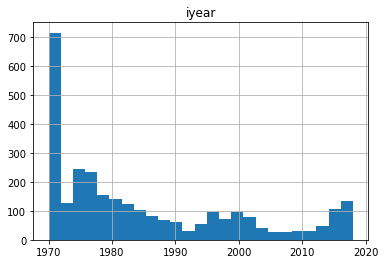

In [136]:
df_cleaned[df_cleaned['country_txt'] == 'United States'][['iyear']].hist(bins=25)

In [145]:
clean_country_list = list(country_data_df['country'].unique())

#### get #incident in each country in each year 

In [181]:
# 183 * 49 list 
# each entry store #incident in each country in each year 
# res[i] correspond to ith country in clean_country_list
incidents_res = []
for country in clean_country_list:
    for year in range(1970, 2019):
        data_year = df_cleaned[df_cleaned['iyear'] == year]
        if year == 1970:
            incidents_res.append([])
        incidents_res[-1].append(sum(data_year['country_txt'] == country))

In [ ]:
#     plt.scatter(test1['year'], test1['number'], alpha=0.3, label='Data');

    # Generate and plot the model fit line
#     xs = np.arange(test1['year'].min(), test1['year'].max())
#     ys = res.params[0] + res.params[1] * xs
#     plt.plot(xs, ys, '--k', linewidth=4, label='Model')

#     plt.xlabel('year')
#     plt.ylabel('number')
#     plt.legend(clean_country_list[i]);
#     plt.title(country)
    
#     plt.cla()   

#### compute incidents rate for each country 

In [234]:
incidents_rate = []  # 183 * 2; each element is two coefficient for each country 
                     # #incident = intercept + coefficient * iyear
for i in range(len(incidents_res)):
    test1 = pd.DataFrame(list(zip(list(range(1970, 2019)), incidents_res[i])), columns =['year', 'number'])
    outcome, predictors = patsy.dmatrices('number ~ year', test1)
    mod = sm.OLS(outcome, predictors)
    res = mod.fit()
    
    incidents_rate.append([res.params[0], res.params[1]])

In [411]:
# for i in range(len(incidents_res)):
#     test1 = pd.DataFrame(list(zip(list(range(1970, 2019)), incidents_res[i])), columns =['year', 'number'])
#     outcome, predictors = patsy.dmatrices('number ~ year', test1)
#     mod = sm.OLS(outcome, predictors)
#     res = mod.fit()
    
# #     ax = plt.subplot(3, 3, i + 1) # nrows, ncols, axes position
        
#     plt.scatter(test1['year'], test1['number'], alpha=0.3, label='Data');

#     # Generate and plot the model fit line
#     xs = np.arange(test1['year'].min(), test1['year'].max())
#     ys = res.params[0] + res.params[1] * xs
#     plt.plot(xs, ys, '--k', linewidth=4, label='Model')

#     plt.xlabel('year')
#     plt.ylabel(clean_country_list[i])
#     plt.show()   

#### use geopandas to plot the incidents rate on world map (cluster countries as 3 categories: increase, constant, decrease)

In [343]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#### data preprocessing to geopandas world map, match countries and remove unnecessary countries

In [344]:
world.name.replace("Bosnia and Herz.", "Bosnia-Herzegovina", inplace=True)
world.name.replace("Côte d'Ivoire", "Ivory Coast", inplace=True)
world.name.replace("Dem. Rep. Congo", "Democratic Republic of the Congo", inplace=True)
world.name.replace("Dominican Rep.", "Dominican Republic", inplace=True)
world.name.replace("United States of America", "United States", inplace=True)
world.name.replace("eSwatini", "Swaziland", inplace=True)
world.name.replace("Timor-Leste", "East Timor", inplace=True)
world.name.replace("Central African Rep.", "Central African Republic", inplace=True)
world.name.replace("Slovakia", "Slovak Republic", inplace=True)
world.name.replace("S. Sudan", "South Sudan", inplace=True)
world.name.replace("Solomon Is.", "Solomon Islands", inplace=True)
world.name.replace("Eq. Guinea", "Equatorial Guinea", inplace=True)
world.name.replace("Czechia", "Czech Republic", inplace=True)
world.name.replace("Congo", "Republic of the Congo", inplace=True)

world = world[(world.pop_est>0) & (world.name!="Antarctica") & (world.name!="Falkland Is.") 
              & (world.name!="Fr. S. Antarctic Lands")
             & (world.name!="Greenland") & (world.name!="Mongolia") & (world.name!="N. Cyprus")
             & (world.name!="Oman") & (world.name!="Palestine") & (world.name!="Puerto Rico")
             & (world.name!="Somaliland") & (world.name!="Taiwan") & (world.name!="W. Sahara")]

#### categorize countries into three classes

In [403]:
# within +/- 0.01 ==> middle 
# > 0.01 ==> increase
# < -0.01 ==> decrease
incident_rate_3cluster = [1 if i >= 0.1 else -1 if i <= -0.1 else 0 for i in [i[1] for i in incidents_rate]]

In [390]:
# mapping between country and class name 
cluster_country_incident_rate_key = clean_country_list
cluster_country_incident_rate_value = incident_rate_3cluster
clster_country_incident_rate_dict = dict(zip(cluster_country_incident_rate_key, cluster_country_incident_rate_value)) 

In [391]:
# mapping between country and incidents rate  
country_incident_rate_key = clean_country_list
country_incident_rate_value = [i[1] for i in incidents_rate]
country_incident_rate_dict = dict(zip(country_incident_rate_key, country_incident_rate_value)) 

#### generate world map (red: increasing incidents; gray: flat; blue: decreasing incidents)

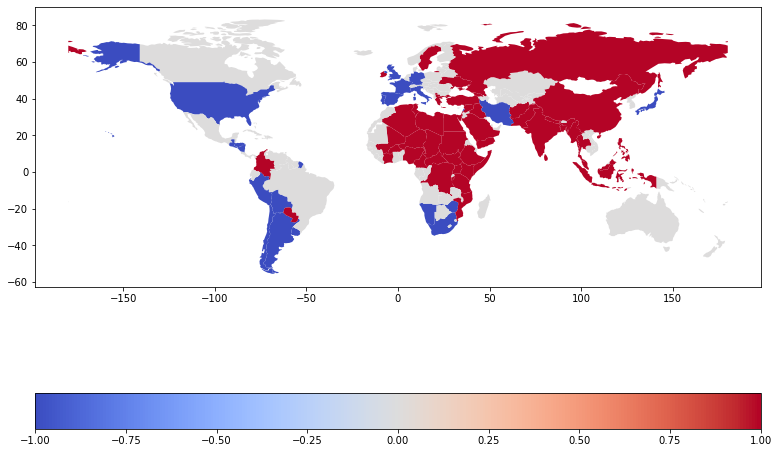

In [410]:
for i in range(world.shape[0]):
    world['incident_rate'][i] = clster_country_incident_rate_dict[world['name'][i]]
world.plot(column='incident_rate',cmap="coolwarm", legend=True,legend_kwds={'orientation': "horizontal"}, figsize=(13,13));